<a href="https://colab.research.google.com/github/souradipta93/NLP/blob/main/text_classification_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify movie reviews using word embedding

In [ ]:
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
#remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))



In [ ]:
#Adding custom stop words
new_words = ["some","one","like","time","br","movie","film","could","good",'even', 'get', 'would',
             'make', 'really', 'see', 'well', 'much', 'great', 'first', 'people', 'also', 'bad', 
             'show', 'way', 'thing', 'made', 'go', 'think', 'know', 'watch','look','many']
stop_words = stop_words.union(new_words)

In [ ]:
df1 = pd.read_csv("imdb1.csv")
df1.head()

,review,sentiment
0,"Ron Hall pulls a triple threat as he writes, d...",negative
1,"The first in the series was brilliant, easily ...",negative
2,I LOVED this movie because Bobbie Phillips can...,positive
3,I was @ 13 yrs of age when I saw this greatly ...,positive
4,The Coen Brothers have truly outdone themselve...,positive


In [ ]:
df1.shape

(2000, 2)

In [ ]:
df1.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
corpus = []
for i in range(0, df1.shape[0]):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df1['review'][i])
    
    #Convert to lowercase
    text = text.lower()
    ##Convert to list from string
    text = text.split()
    ##Lemmatizing
    lm = WordNetLemmatizer() 
       
    
    text = [lm.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [ ]:
len(corpus)

2000

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 80000
# Max number of words in each sentence.
MAX_SEQUENCE_LENGTH = 75
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,  lower=False)
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22042 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2000, 75)


In [ ]:
X[2]

array([ 257, 4607, 5250,  288,   81,  522,    6,  858,   64,   34, 7297,
         38, 9182, 2583,  966,  216,  859, 1117,   64,    5,  412,  261,
        115,  374,  101,  154,  288, 2921,   14, 1487,  195,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
Y = pd.get_dummies(df1['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2000, 2)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1800, 75) (1800, 2)
(200, 75) (200, 2)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 100)           8000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 75, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 8,080,602
Trainable params: 8,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 2
batch_size = 100

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                             patience=3, 
                                             min_delta=0.0001)])

Epoch 1/2
17/17 [==============================] - 35s 415ms/step - loss: 0.6943 - accuracy: 0.4885 - val_loss: 0.6995 - val_accuracy: 0.4500
Epoch 2/2
17/17 [==============================] - 6s 359ms/step - loss: 0.6889 - accuracy: 0.5242 - val_loss: 0.6975 - val_accuracy: 0.5389


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 0s 19ms/step - loss: 0.6899 - accuracy: 0.5950
Test set
  Loss: 0.690
  Accuracy: 0.595


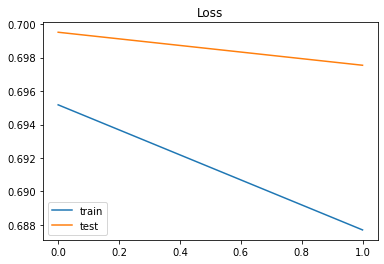

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();